In [9]:
# تحميل البيانات من ملفك المحلي /content/archive (3).zip
import pandas as pd
import numpy as np
import zipfile
import os

print("📥 جاري تحميل البيانات من ملفك المحلي...")

# المسار إلى ملفك
file_path = '/content/archive (3).zip'

if os.path.exists(file_path):
    print(f"✅ الملف موجود: {file_path}")

    # فك الضغط وقراءة البيانات
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # عرض جميع الملفات داخل الأرشيف
        file_list = zip_ref.namelist()
        print(f"📁 الملفات داخل الأرشيف: {file_list}")

        # استخراج جميع الملفات
        zip_ref.extractall('/content/extracted_data')
        print("✅ تم فك ضغط الملف")

    # البحث عن ملفات CSV في المجلد المستخرج
    extracted_folder = '/content/extracted_data'
    csv_files = [f for f in os.listdir(extracted_folder) if f.endswith('.csv')]

    if csv_files:
        print(f"📄 وجدنا {len(csv_files)} ملف CSV:")
        for csv_file in csv_files:
            print(f"   - {csv_file}")

        # قراءة أول ملف CSV
        first_csv = os.path.join(extracted_folder, csv_files[0])
        df = pd.read_csv(first_csv)
        print(f"✅ تم تحميل: {csv_files[0]}")

    else:
        print("❌ لم يتم العثور على ملفات CSV في الأرشيف")
        df = None

else:
    print(f"❌ الملف غير موجود: {file_path}")
    df = None

if df is not None:
    print(f"\n🎉 تم تحميل البيانات بنجاح!")
    print(f"📊 شكل البيانات: {df.shape}")
    print(f"📋 أعمدة البيانات: {df.columns.tolist()}")

    print("\n📋 عينة من البيانات:")
    display(df.head(3))

    print(f"\n🔍 معلومات إضافية:")
    print(f"نطاق التواريخ: من {df.iloc[0,0]} إلى {df.iloc[-1,0]}" if len(df) > 0 else "لا توجد بيانات")
else:
    print("❌ فشل تحميل البيانات")

📥 جاري تحميل البيانات من ملفك المحلي...
✅ الملف موجود: /content/archive (3).zip
📁 الملفات داخل الأرشيف: ['cleaned_sales_data.csv', 'country_segments.csv']
✅ تم فك ضغط الملف
📄 وجدنا 2 ملف CSV:
   - country_segments.csv
   - cleaned_sales_data.csv
✅ تم تحميل: country_segments.csv

🎉 تم تحميل البيانات بنجاح!
📊 شكل البيانات: (48, 8)
📋 أعمدة البيانات: ['Country', 'total_sales', 'orders_count', 'units_sold_total', 'total_profit', 'avg_order_value', 'profit_margin', 'segment']

📋 عينة من البيانات:


,Country,total_sales,orders_count,units_sold_total,total_profit,avg_order_value,profit_margin,segment
0,Albania,32224853.87,21,90608,10490706.02,1.534517e+06,0.325547,1
1,Andorra,47756693.17,40,185686,15410036.63,1.193917e+06,0.322678,0
2,Armenia,37519840.21,29,150665,9422353.18,1.293788e+06,0.251130,0



🔍 معلومات إضافية:
نطاق التواريخ: من Albania إلى Vatican City


In [ ]:
# خلية التنظيف التالية (انسخيها وشغّليها)
import pandas as pd
import numpy as np

df = df.rename(columns={
    'Order Date': 'OrderDate',
    'Ship Date': 'ShipDate',
    'Order ID': 'OrderID',
    'Item Type': 'ItemType',
    'Sales Channel': 'SalesChannel',
    'Order Priority': 'OrderPriority',
    'Units Sold': 'UnitsSold',
    'Unit Price': 'UnitPrice',
    'Unit Cost': 'UnitCost',
    'Total Revenue': 'TotalRevenue',
    'Total Cost': 'TotalCost',
    'Total Profit': 'TotalProfit'
})

# 2) تحويل التواريخ — نجرب التحويل بصيغة شائعة أولاً (month/day/year)، وإذا فشل نعيد بمحاولة dayfirst=True
def robust_parse_dates(series):
    s1 = pd.to_datetime(series, errors='coerce', infer_datetime_format=True, dayfirst=False)
    na_count = s1.isna().sum()
    # إذا وجدنا كثير من القيم غير قابلة للتحويل نعيد المحاولة بـ dayfirst=True
    if na_count > (0.01 * len(series)):  # إذا أكثر من 1% لم تتحول
        s2 = pd.to_datetime(series, errors='coerce', infer_datetime_format=True, dayfirst=True)
        # اختر الأفضل (أقل قيم NaT)
        return s2 if s2.isna().sum() < na_count else s1
    return s1

df['OrderDate'] = robust_parse_dates(df['OrderDate'])
df['ShipDate'] = robust_parse_dates(df['ShipDate'])

# 3) حذف الصفوف التي لا تحتوي على معرف الطلب أو تاريخ صالح (لايمكن تحليلها)
before = len(df)
df = df.dropna(subset=['OrderID', 'OrderDate'])
print(f"Removed {before - len(df)} rows missing OrderID or valid OrderDate")

# 4) إزالة المكررات الكاملة (إن وُجدت)
before = len(df)
df = df.drop_duplicates()
print(f"Removed {before - len(df)} duplicate rows")

# 5) تحويل الأعمدة الرقمية (احتمال وجود نصوص/مسافات) — نحرر الفواصل ونحوّل
num_cols = ['UnitsSold','UnitPrice','UnitCost','TotalRevenue','TotalCost','TotalProfit']
for c in num_cols:
    if c in df.columns:
        # إزالة مسافات وcommas ثم تحويل إلى float
        df[c] = (df[c].astype(str)
                         .str.replace(',','')      # تحوير لو كان هناك فواصل آلاف
                         .str.replace(r'\s+','')   # إزالة فراغات
                         .replace({'nan':'', 'None':''})
                  )
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 6) إن لم يوجد عمود TotalRevenue نحسب Sales من UnitsSold * UnitPrice
if 'TotalRevenue' not in df.columns or df['TotalRevenue'].isna().all():
    df['Sales'] = df['UnitsSold'] * df['UnitPrice']
else:
    df['Sales'] = df['TotalRevenue']

# 7) تعبئة القيم المفقودة المقبولة أو الإشارة إليها
# مثال: إن وجد UnitPrice مفقود نملأ بالمتوسط الخاص بفئة المنتج إن وُجد، وإلا بالوسيط العام
if 'UnitPrice' in df.columns:
    median_price = df['UnitPrice'].median()
    df['UnitPrice'] = df['UnitPrice'].fillna(median_price)

# 8) إنشاء أعمدة زمنية مفيدة
df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['MonthName'] = df['OrderDate'].dt.strftime('%b')
df['Weekday'] = df['OrderDate'].dt.day_name()

# 9) لمحة سريعة لنتأكد أن كل شيء معقول
print("\n--- Quick checks ---")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("Nulls per important column:")
print(df[['OrderID','OrderDate','UnitsSold','UnitPrice','Sales']].isnull().sum())

# طباعة عينات لرؤية النتيجة
display(df.head(6))


Removed 0 rows missing OrderID or valid OrderDate
Removed 0 duplicate rows

--- Quick checks ---
Rows: 1330
Columns: ['Region', 'Country', 'ItemType', 'SalesChannel', 'OrderPriority', 'OrderDate', 'OrderID', 'ShipDate', 'UnitsSold', 'UnitPrice', 'UnitCost', 'TotalRevenue', 'TotalCost', 'TotalProfit', 'Sales', 'Year', 'Month', 'MonthName', 'Weekday']
Nulls per important column:
OrderID      0
OrderDate    0
UnitsSold    0
UnitPrice    0
Sales        0
dtype: int64


/tmp/ipython-input-2823107453.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s1 = pd.to_datetime(series, errors='coerce', infer_datetime_format=True, dayfirst=False)
/tmp/ipython-input-2823107453.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s1 = pd.to_datetime(series, errors='coerce', infer_datetime_format=True, dayfirst=False)


,Region,Country,ItemType,SalesChannel,OrderPriority,OrderDate,OrderID,ShipDate,UnitsSold,UnitPrice,UnitCost,TotalRevenue,TotalCost,TotalProfit,Sales,Year,Month,MonthName,Weekday
0,Europe,Czech Republic,Beverages,Offline,C,2011-09-12,478051030,2011-09-29,4778,47.45,31.79,226716.10,151892.62,74823.48,226716.10,2011,9,Sep,Monday
1,Europe,Bosnia and Herzegovina,Clothes,Online,M,2013-10-14,919133651,2013-11-04,927,109.28,35.84,101302.56,33223.68,68078.88,101302.56,2013,10,Oct,Monday
2,Europe,Austria,Cereal,Offline,C,2014-08-13,987410676,2014-09-06,5616,205.70,117.11,1155211.20,657689.76,497521.44,1155211.20,2014,8,Aug,Wednesday
3,Europe,Bulgaria,Office Supplies,Online,L,2010-10-31,672330081,2010-11-29,6266,651.21,524.96,4080481.86,3289399.36,791082.50,4080481.86,2010,10,Oct,Sunday
4,Europe,Estonia,Fruits,Online,L,2016-09-28,579463422,2016-11-01,4958,9.33,6.92,46258.14,34309.36,11948.78,46258.14,2016,9,Sep,Wednesday
5,Europe,Montenegro,Fruits,Offline,L,2016-05-29,313705861,2016-07-10,1390,9.33,6.92,12968.70,9618.80,3349.90,12968.70,2016,5,May,Sunday


/tmp/ipython-input-1069086595.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_ts['Sales'].resample('M').sum()


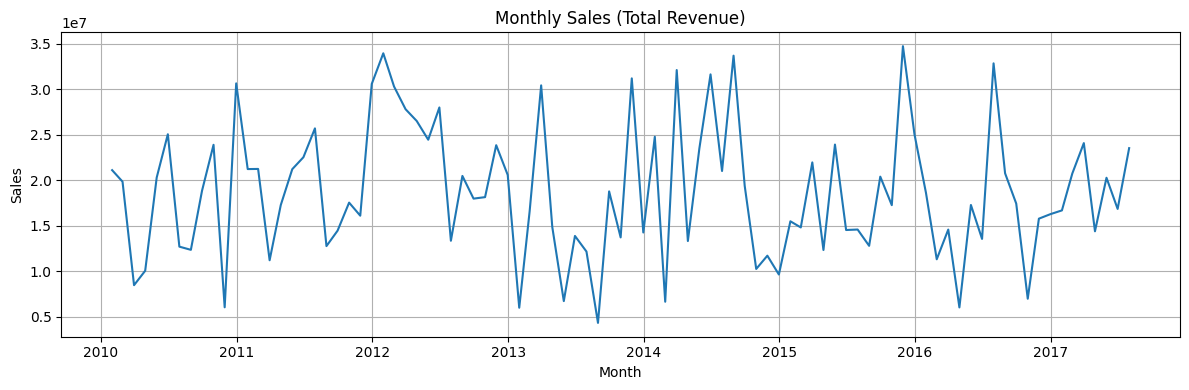

Monthly sales — first 5 months:
 OrderDate
2010-01-31    21115354.48
2010-02-28    19853023.20
2010-03-31     8474747.19
2010-04-30    10058016.05
2010-05-31    20304725.59
Freq: ME, Name: Sales, dtype: float64
Monthly sales — last 5 months:
 OrderDate
2017-03-31    24088987.50
2017-04-30    14397482.38
2017-05-31    20279233.36
2017-06-30    16855010.05
2017-07-31    23536290.16
Freq: ME, Name: Sales, dtype: float64


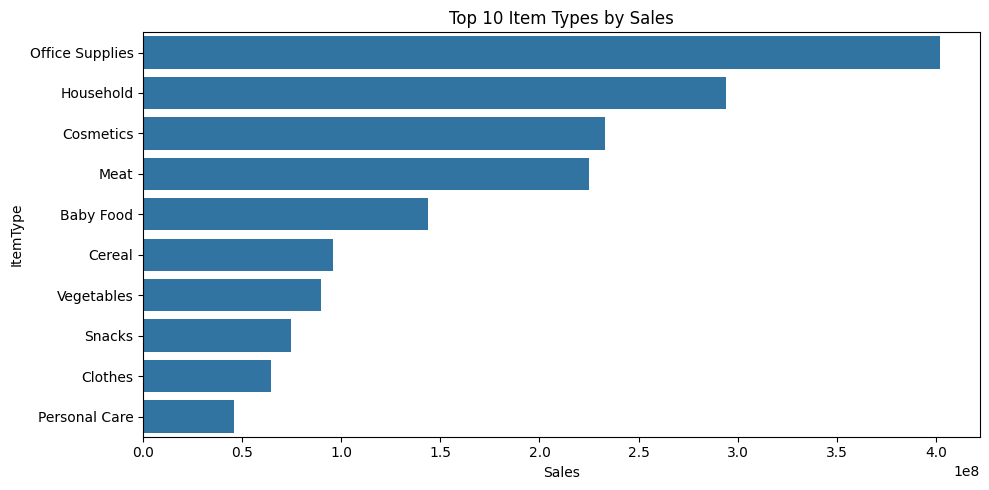

Top Products:
 ItemType
Office Supplies    4.022140e+08
Household          2.942052e+08
Cosmetics          2.331548e+08
Meat               2.250260e+08
Baby Food          1.436476e+08
Cereal             9.579140e+07
Vegetables         8.974673e+07
Snacks             7.478861e+07
Clothes            6.462655e+07
Personal Care      4.580803e+07
Name: Sales, dtype: float64


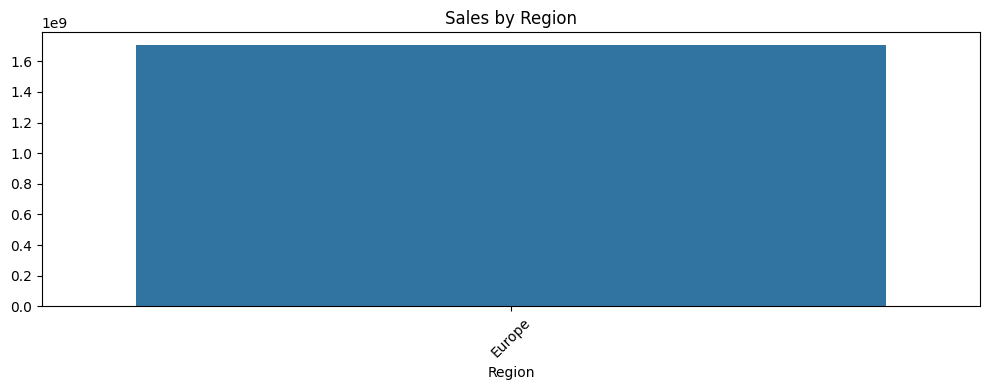

Sales by Region:
 Region
Europe    1.703622e+09
Name: Sales, dtype: float64


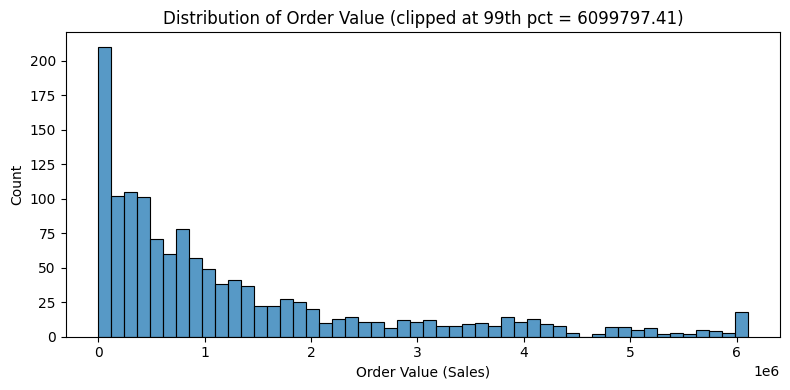

Order value statistics:
 count    1.330000e+03
mean     1.280919e+06
std      1.443065e+06
min      5.038200e+02
25%      2.661169e+05
50%      7.613049e+05
75%      1.742756e+06
max      6.672676e+06
Name: Sales, dtype: float64


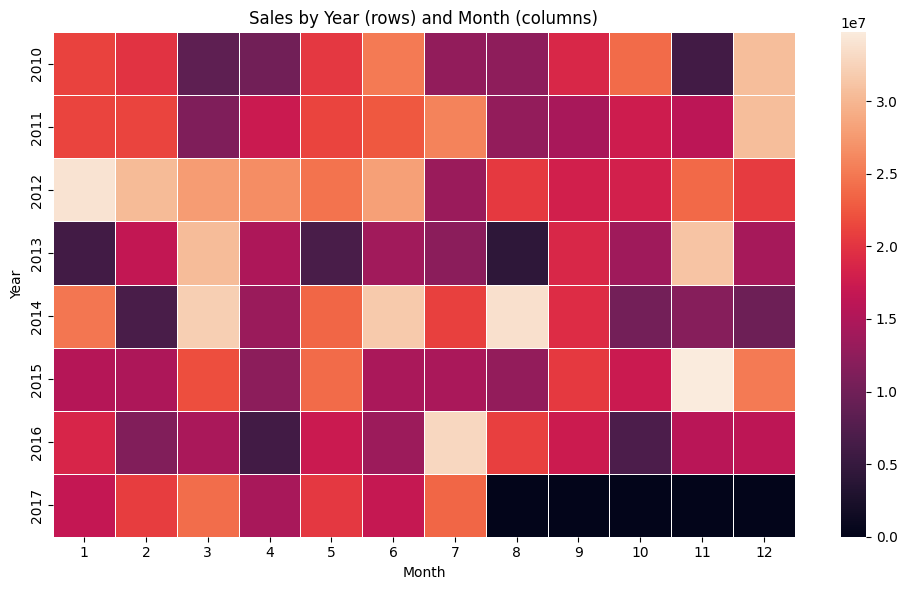

In [ ]:
# خلية: رسومات EDA أساسية (انسخيها وشغّليها)
import matplotlib.pyplot as plt
import seaborn as sns

# تأكد أن OrderDate هو index مؤقت للسلسلة الزمنية
df_ts = df.set_index('OrderDate').sort_index()

# 1) مبيعات شهرية (سلسلة زمنية)
monthly_sales = df_ts['Sales'].resample('M').sum()
plt.figure(figsize=(12,4))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title('Monthly Sales (Total Revenue)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# اعرض ملخص سريع للاتجاه
print("Monthly sales — first 5 months:\n", monthly_sales.head())
print("Monthly sales — last 5 months:\n", monthly_sales.tail())

# 2) أفضل 10 منتجات حسب إجمالي المبيعات
top_products = df.groupby('ItemType')['Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Item Types by Sales')
plt.xlabel('Sales')
plt.tight_layout()
plt.show()

print("Top Products:\n", top_products)

# 3) المبيعات حسب المنطقة (Region)
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(x=region_sales.index, y=region_sales.values)
plt.title('Sales by Region')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Sales by Region:\n", region_sales)

# 4) توزيع قيمة الطلب (Order Value) — نحسب قيمة كل طلب ثم نرسم هيستوجرام (نقصم القيم الشاذة بالـ 99th percentile للعرض)
order_values = df.groupby('OrderID')['Sales'].sum()
p99 = order_values.quantile(0.99)

plt.figure(figsize=(8,4))
sns.histplot(order_values.clip(upper=p99), bins=50)
plt.title(f'Distribution of Order Value (clipped at 99th pct = {p99:.2f})')
plt.xlabel('Order Value (Sales)')
plt.tight_layout()
plt.show()

print("Order value statistics:\n", order_values.describe())

# 5) (اختياري مفيد) مبيعات حسب السنة-الشهر (heatmap) — يساعد على رؤية الموسمية
pivot_ym = df.pivot_table(values='Sales', index='Year', columns='Month', aggfunc='sum', fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_ym, annot=False, fmt=".0f", linewidths=.5)
plt.title('Sales by Year (rows) and Month (columns)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


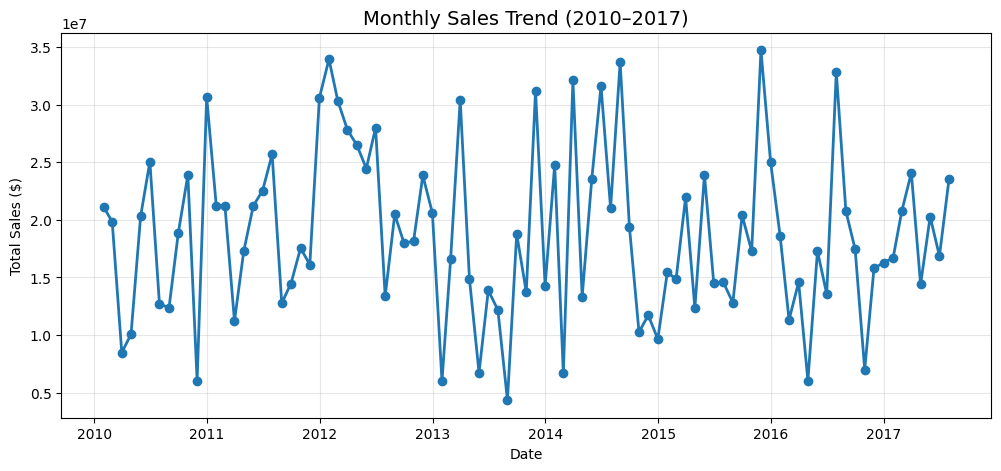

In [ ]:
# 📊 تطور المبيعات الشهرية مع الزمن
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', linewidth=2)
plt.title('Monthly Sales Trend (2010–2017)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True, alpha=0.3)
plt.show()


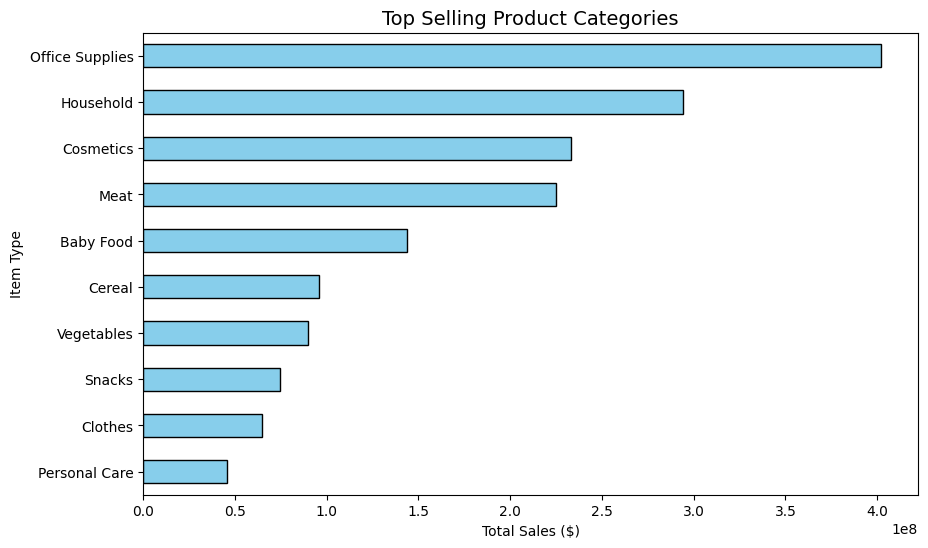

In [ ]:
# 🏆 المنتجات الأعلى مبيعًا
top_products.sort_values(ascending=True).plot(
    kind='barh', figsize=(10,6), color='skyblue', edgecolor='black'
)
plt.title('Top Selling Product Categories', fontsize=14)
plt.xlabel('Total Sales ($)')
plt.ylabel('Item Type')
plt.show()


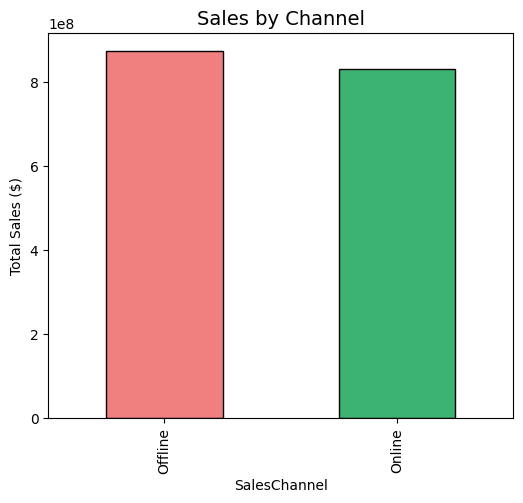

,Sales
SalesChannel,
Offline,8.732536e+08
Online,8.303688e+08


In [ ]:
# 📦 مبيعات القنوات
sales_by_channel = df.groupby('SalesChannel')['Sales'].sum()

sales_by_channel.plot(
    kind='bar',
    figsize=(6,5),
    color=['lightcoral', 'mediumseagreen'],
    edgecolor='black'
)
plt.title('Sales by Channel', fontsize=14)
plt.ylabel('Total Sales ($)')
plt.show()

sales_by_channel


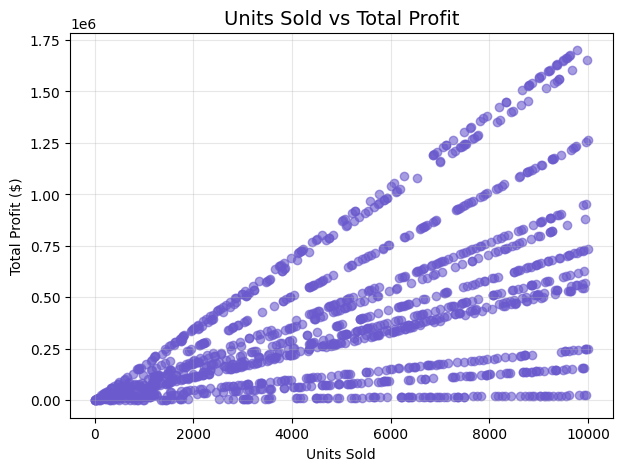

In [ ]:
# 💰 العلاقة بين الوحدات المباعة والأرباح
plt.figure(figsize=(7,5))
plt.scatter(df['UnitsSold'], df['TotalProfit'], alpha=0.6, color='slateblue')
plt.title('Units Sold vs Total Profit', fontsize=14)
plt.xlabel('Units Sold')
plt.ylabel('Total Profit ($)')
plt.grid(True, alpha=0.3)
plt.show()


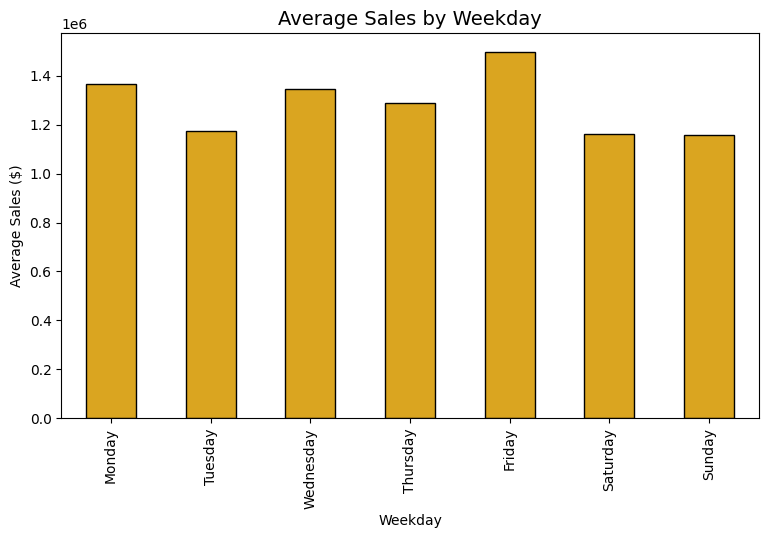

,Sales
Weekday,
Monday,1.364839e+06
Tuesday,1.173704e+06
Wednesday,1.346473e+06
Thursday,1.286959e+06
Friday,1.498903e+06
Saturday,1.162394e+06
Sunday,1.157251e+06


In [ ]:
# 📆 المبيعات حسب يوم الأسبوع
weekday_sales = df.groupby('Weekday')['Sales'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

weekday_sales.plot(
    kind='bar',
    figsize=(9,5),
    color='goldenrod',
    edgecolor='black'
)
plt.title('Average Sales by Weekday', fontsize=14)
plt.ylabel('Average Sales ($)')
plt.show()

weekday_sales


In [ ]:
# خلية A: تحضير بيانات التجميع لكل Country (أو لكل Customer لو توافرت CustomerID)
import pandas as pd
import numpy as np

# افتراض: df موجود بالفعل من الخلايا السابقة
# إن لم يكن، قومي بقراءة الملف هنا:
# df = pd.read_csv('sales_data.csv', parse_dates=['OrderDate'], low_memory=False)

# Aggregate by Country as proxy for customers
agg_by_country = df.groupby('Country').agg(
    total_sales=('Sales','sum'),
    orders_count=('OrderID','nunique'),
    units_sold_total=('UnitsSold','sum'),
    total_profit=('TotalProfit','sum'),
    avg_order_value=('Sales', lambda s: s.sum()/s.nunique() if s.nunique()>0 else 0)
).reset_index()

agg_by_country['profit_margin'] = np.where(
    agg_by_country['total_sales']>0,
    agg_by_country['total_profit'] / agg_by_country['total_sales'],
    0
)

# نظرة سريعة
agg_by_country.sort_values('total_sales', ascending=False).head(10)


,Country,total_sales,orders_count,units_sold_total,total_profit,avg_order_value,profit_margin
22,Kosovo,53833142.79,35,177589,14409145.45,1.538090e+06,0.267663
10,Czech Republic,53543932.14,31,142446,13635593.78,1.727224e+06,0.254662
45,Ukraine,53252317.54,33,164577,14804925.74,1.613707e+06,0.278015
6,Bosnia and Herzegovina,50117508.49,33,153545,13257602.77,1.518712e+06,0.264530
27,Macedonia,49222085.25,32,203078,13684099.95,1.538190e+06,0.278007
38,San Marino,47883708.48,40,192228,13792992.81,1.197093e+06,0.288052
1,Andorra,47756693.17,40,185686,15410036.63,1.193917e+06,0.322678
35,Portugal,47172189.84,25,124825,11345407.59,1.886888e+06,0.240511
28,Malta,47145320.81,32,173641,14610127.88,1.473291e+06,0.309896
37,Russia,46051659.81,32,165954,13267682.64,1.439114e+06,0.288104


In [ ]:
# خلية C: ملخص لكل Segment وحفظ النتائج للتصدير إلى Power BI
seg_summary = agg_by_country.groupby('segment').agg(
    countries=('Country','count'),
    total_sales=('total_sales','sum'),
    avg_order_value=('avg_order_value','mean'),
    avg_profit_margin=('profit_margin','mean'),
    total_units=('units_sold_total','sum'),
    orders_count=('orders_count','sum')
).reset_index().sort_values('total_sales', ascending=False)

print(seg_summary)

# حفظ ملفات CSV للتصدير إلى Power BI
agg_by_country.to_csv('country_segments.csv', index=False)      # ملف التفاصيل per country
seg_summary.to_csv('segment_summary.csv', index=False)         # ملخص per segment
df.to_csv('cleaned_sales_data.csv', index=False)              # ملف البيانات بعد التنظيف (إن لم تُحفظ)
print("Saved: country_segments.csv, segment_summary.csv, cleaned_sales_data.csv")


   segment  countries   total_sales  avg_order_value  avg_profit_margin  \
0        0         23  9.988395e+08     1.426830e+06           0.286527   
1        1         25  7.047829e+08     1.133547e+06           0.306409   

   total_units  orders_count  
0      3659599           706  
1      2922723           624  
Saved: country_segments.csv, segment_summary.csv, cleaned_sales_data.csv
